<a href="https://colab.research.google.com/github/ITU-Business-Analytics-Team/Business_Analytics_for_Professionals/blob/main/Part%20II%20%3A%20Business%20Applications/Chapter%2011%3A%20Supply%20Chain%20Analytics/11_5_Route_Planning_and_Transportation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Supply Chain Analytics**
## Route Planning and Transportation 


RPT is aimed to find the most suitable route with the least cost and under certain constraints.


Sometimes the energy cost is targeted, sometimes the shortest time is aimed, while the least distance is targeted in this problem.



## CASE STUDY

ATK-Cargo has a main distribution center in Uşak to serve the customers located in the Aegean region in Turkey. The company first carries out the customer cargo to province centers via trucks and then delivers the intra-city shipments via small vehicles. The company purchased two trucks for delivering costumer cargoes from main station to other cities in the Aegean region.  Each truck is to return to the main station (Uşak) after delivering cargoes. The company cannot load more than 30 tons or 80 cubic meters for each truck as per the legislation. The trucks are expected to distribute the freights to all the locations in the Aegean region. The load of each truck can only differ up to 4 tons. In addition, there may be a difference of up to 10 cubic meters between the volumes of the loads included in each truck. The company wants to distribute the loads evenly on the trucks. Therefore, the deviation of each truck’s load in terms of both weight and volume from the average loads (per truck) can be at most 10%. 





In [ ]:
!pip install -q pyomo

In [ ]:
!apt-get install -y -qq glpk-utils

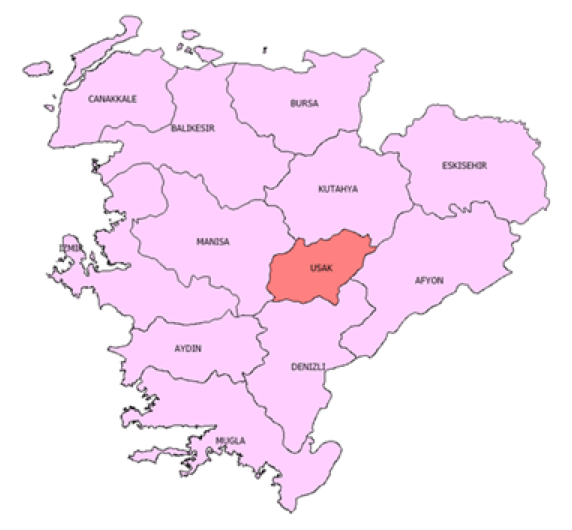

In [ ]:
import numpy as np
import pandas as pd
import math
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as img


url=   'https://drive.google.com/file/d/1WMz3ygaeUe_YR2yVNFZD_eNYbOItEBn6/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
img = img.imread(path)
plt.subplots(figsize=(10, 10))
plt. axis("off")
imgplot = plt.imshow(img)


In [ ]:
url=   'https://drive.google.com/file/d/1Tu4cXAQi1jhE6GfPu_ucl7JBiweU_0gJ/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path) 
d = pd.DataFrame(data)
d.iloc[0:13]

,Distance,Usak,Afyon,Aydin,Balikesir,Bursa,Çanakkale,Denizli,Eskisehir,Izmir,Kütahya,Manisa,Mugla
0,Usak,0,114,155,153,176,262,95,191,191,72,165,185
1,Afyon,114,0,261,245,214,354,169,116,306,117,280,268
2,Aydin,155,261,0,188,279,257,109,346,87,212,92,84
3,Balikesir,153,245,188,0,114,109,216,262,146,130,114,264
4,Bursa,176,214,279,114,0,182,267,180,257,109,224,342
5,Çanakkale,262,354,257,109,182,0,314,356,183,237,165,341
6,Denizli,95,169,109,216,267,314,0,273,184,167,172,99
7,Eskisehir,191,116,346,262,180,356,273,0,368,143,336,371
8,Izmir,191,306,87,146,257,183,184,368,0,224,33,170
9,Kütahya,72,117,212,130,109,237,167,143,224,0,192,255


In [ ]:
url=   'https://drive.google.com/file/d/1o_pG7iZewznUg29aj5qUj953Xq2XKydp/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path) 
cp = pd.DataFrame(data)
cp.iloc[0:2]

,Table 2,USAK,AFYON,AYDIN,BALIKESIR,BURSA,CANAKKALE,DENIZLI,ESKISEHIR,IZMIR,KUTAHYA,MANISA,MUGLA
0,Cargo weight / Tons,0,2,4,3,6,5,3,6,8,4,5,6
1,Cargo volume/ m3,0,9,12,5,15,16,7,19,22,13,12,15


In [ ]:
model = pyo.ConcreteModel()

# Parameters

**Indies:**
$i$, $j$, $z$: cities in the Aegean    
$k$: number of  truck ($1, 2 = k$)
Parameters
$p_j:$ Cargo weight belonging to city $j$. 

$c_j:$ Cargo volume of city  $j$. 

$d_{ij}:$  Distance between city $i$ and city $j$ (km).

$Sdw: ± 10$%"deviation values of half of the total weight (Allowance veriable 23,4 and 28,6).

$Sdv: ± 10$% deviation values of half of the total volume (Allowance veriable 65,25 and 79,75).


**Scalar:**

$b$:  maximum load carrying capacity (30 ton)

$s$: maximum transport volume (80 cubic meter)


In [ ]:

V = range(1,13)
S=range(1,13)
K=range (1,3)
L=range(1,3)
d=      {(1, 2): 114, (1, 3): 155,(1, 4): 153, (1, 5): 176, (1, 6): 262, (1, 7): 95,(1, 8): 191, (1, 9): 191, (1, 10): 72, (1, 11): 165, (1, 12): 185,   
         (2, 1): 114, (2, 3): 261, (2, 4): 245, (2, 5): 214, (2, 6): 354 ,(2, 7): 169, (2, 8): 116,  (2, 9): 306,(2, 10): 117, (2, 11): 280, (2, 12): 268,   
         (3, 1): 155,(3, 2): 261, (3, 4): 188,(3, 5): 279, (3, 6): 257, (3, 7): 109,  (3, 8): 348,  (3, 9): 87,  (3, 10): 212, (3, 11): 92, (3, 12): 84,     
         (4, 1): 153,(4, 2): 245, (4, 3): 188, (4, 5): 114, (4, 6): 109,  (4, 7): 216, (4, 8): 262, (4, 9): 146, (4, 10): 130, (4, 11): 114,  (4, 12): 264, 
         (5, 1): 176, (5,2): 214, (5, 3): 279, (5, 4): 114, (5, 6):  182,  (5, 7): 267,(5, 8): 180, (5, 9): 257,(5, 10): 109, (5, 11): 224,(5, 12): 342, 
         (6, 1): 262,(6, 2): 354, (6, 3): 257, (6, 4): 109,  (6, 5): 182,(6, 7): 314, (6, 8): 356,(6, 9): 183, (6, 10): 237,(6, 11): 165,  (6, 12): 341, 
         (7, 1): 95, (7, 2): 169, (7, 3): 109,  (7, 4): 216,(7, 5): 267, (7,6): 314,(7, 8): 273, (7, 9): 184,(7, 10): 167,(7, 11): 172, (7, 12): 99, 
         (8, 1): 191,(8, 2): 116, (8, 3): 346,(8, 4): 262, (8, 5): 180,(8, 6): 356, (8, 7): 273,(8, 9): 368, (8, 10): 143, (8, 11): 336,(8, 12): 371, 
         (9, 1): 191,(9, 2): 306,    (9, 3): 87, (9, 4): 146,  (9, 5): 257,(9, 6): 183, (9, 7): 184,(9, 8): 368,  (9, 10): 224,(9, 11): 33, (9, 12): 170,       
         (10, 1): 1, (10, 2): 1,  (10, 3): 0,(10, 4): 1, (10, 5): 1, (10, 6): 0,(10, 7): 0, (10, 8): 1,  (10, 9): 0,(10, 11): 1,  (10, 12): 0, (10, 13): 1, 
         (11, 1): 165, (11, 2): 280, (11, 3): 92, (11, 4): 114, (11, 5): 224,(11, 6): 165, (11, 7): 172,  (11, 8): 336,(11, 9): 33, (11, 10): 192,  (11, 12): 177,
         (12, 1): 185,(12, 2): 268,(12, 3): 84, (12, 4): 264,(12, 5): 342,(12, 6): 341, (12, 7):99 , (12, 8): 371,(12, 9): 170, (12, 10): 255,(12, 11): 177} 
p=[0,2,4,3,6,5,3,6,8,4,5,6]
c=[0,9,12,5,15,16,7,19,22,13,12,15]


b=30
s=80
n=12
sdw=0.1
sdv=0.1
w=np.sum(p)*0.5
v=np.sum(c)*0.5


**Desicion veriable:**

$x_{ijk} :$ Whether or not the cities i and j are in the k truck route.

$u_{ij}:$  Sub-tour variable

 



# Desicion Variables

The decision variables used to solve the problem are defined below.


In [ ]:
model = pyo.ConcreteModel()
model.x = pyo.Var(V,S,K, domain = pyo.Binary)  
model.u= pyo.Var(V,S, domain = pyo.NonNegativeIntegers)

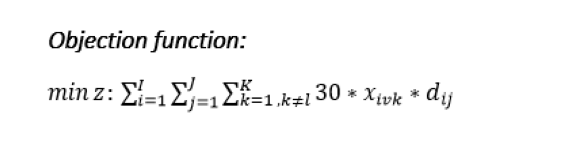

In [ ]:
import matplotlib.image as img
url=   'https://drive.google.com/file/d/1Ruba9FnPo3PS7LaZUQ1xKy-ocTctN2Jj/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
img1 = img.imread(path)
#img1 = img.imread('Objection_function.png')
plt.subplots(figsize=(10, 10))
plt. axis("off")
imgplot = plt.imshow(img1)



# Objective Function

**30** is a **variable cost**. The cost will increase with the length of the road. however, **fixed costs** may be encountered in some problems.

In [ ]:
model.obj_val = pyo.Objective(expr = (30*sum (model.x[i,j,k] * d[i,j] for i in V for j in V if j!=i for k in K)) ,sense = pyo.minimize) 


# Subject to:


$u_{ij} ≥  1 $            $∀ i, j $

$u_{ij} ≤  n $                 $ ∀ i, j $

$u_{ij}-u_{ji}+1≤(n-1)(1-x_ijk)  $   $∀ i, j, k $                                                                                    


In [ ]:
model.subtour = pyo.ConstraintList()
for i in range(2,13):
    for j in range(2,13):
        if j != i:
            model.subtour.add(model.u[i,j]>=1)
            model.subtour.add(model.u[i,j]<=n)
for i in range(2,13):
    for j in range(2,13):
        if j != i:
            for k in range(1,3):
                model.subtour.add(model.u[i,k]-model.u[j,k]+1 <= (n-1)*(1-model.x[i,j,k])) 


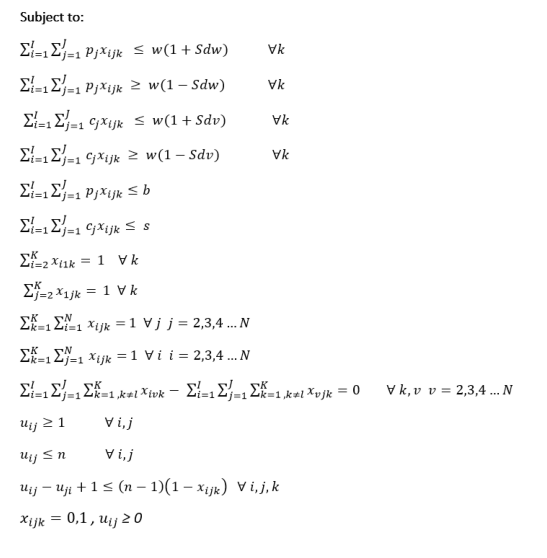

In [ ]:
import matplotlib.image as img
url=   'https://drive.google.com/file/d/1cVBPsrZ7IZrVA84BQtwkfchc_WO7DClZ/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
img2 = img.imread(path)
#img2 = img.imread('Equations.png')
plt.subplots(figsize=(10, 10))
plt. axis("off")
imgplot = plt.imshow(img2)

In [ ]:
model.vtour = pyo.ConstraintList()
model.vtour.add(sum(model.x[i,j,1]*p[j-1] for i  in V for j in S if i != j) <=round(w*(1+sdw)))
model.vtour.add(sum(model.x[i,j,2]*p[j-1] for i  in V for j in S if i != j) <=round(w*(1+sdw)))
model.vtour.add(sum(model.x[i,j,1]*p[j-1] for i  in V for j in S if i != j) >=round(w*(1-sdw)))
model.vtour.add(sum(model.x[i,j,2]*p[j-1] for i  in V for j in S if i != j) >=round(w*(1-sdw)))
model.vtour.add(sum(model.x[i,j,1]*c[j-1] for i  in V for j in S if i != j) <=round(v*(1+sdv)))
model.vtour.add(sum(model.x[i,j,2]*c[j-1] for i  in V for j in S if i != j) <=round(v*(1+sdv)))
model.vtour.add(sum(model.x[i,j,1]*c[j-1] for i  in V for j in S if i != j) >=round(v*(1-sdv)))
model.vtour.add(sum(model.x[i,j,2]*c[j-1] for i  in V for j in S if i != j) >=round(v*(1-sdv)))

for k in K:
    model.vtour.add(sum(model.x[i,j,k]*p[j-1] for i  in V for j in S if i != j) <=b)
    model.vtour.add(sum(model.x[i,j,k]*c[j-1] for i  in V for j in S if i != j) <=s)

model.ktour = pyo.ConstraintList()
for j in range (2,13):
        model.ktour.add(sum(model.x[i,j,k] for i in range (1,13) if i != j for k in K)==1)
for i in range (2,13):
        model.ktour.add(sum(model.x[i,j,k] for j in range (1,13) if i != j for k in K)==1) 
model.xtour = pyo.ConstraintList()
for k in K:
    model.xtour.add(sum(model.x[i,1,k] for i in range (2,13) if i!=j)==1)
    model.xtour.add(sum(model.x[1,j,k] for j in range (2,13) if i!=j)==1)
    
model.btour = pyo.ConstraintList()
for l in range (2,13):
    for k in K:
        model.btour.add(sum(model.x[i,l,k] for i  in range (1,13)  if i != l ) == sum(model.x[l,j,k] for j  in range (1,13)  if j!=l) )


# Optimal  Route

Since the problem is linear, the "glpk" solver is used.

In [ ]:
opt = pyo.SolverFactory("glpk")
opt.solve(model) 
for i in V:
    for j in S:
        if j != i:
            for k in range(1,3):
                if pyo.value(model.x[i,j,k]) > 0:
                    print(pyo.value(model.x[i,j,k]), model.x[i,j,k])
print("Route:", pyo.value(model.obj_val))

1.0 x[1,10,2]
1.0 x[1,11,1]
1.0 x[2,1,2]
1.0 x[3,12,1]
1.0 x[4,5,2]
1.0 x[5,8,2]
1.0 x[6,4,2]
1.0 x[7,1,1]
1.0 x[8,2,2]
1.0 x[9,3,1]
1.0 x[10,6,2]
1.0 x[11,9,1]
1.0 x[12,7,1]
Route: 38040.0


Above!  the decision variables took the value 1.

This value indicates that this route will be used.

The final values of the variables are 1 or 2. These values represent the route that the 1st truck or the 2nd truck will use.

In [ ]:
sets ={1,2}
nodes = {1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12}
edges={(1, 2),(1, 3), (1, 4), (1, 5), (1, 6),(1, 7), (1, 8), (1, 9), (1, 10),(1, 11), (1, 12),  
        (2, 1),(2, 3), (2, 4), (2, 5), (2, 6),(2, 7), (2, 8), (2, 9), (2, 10),(2, 11), (2, 12), 
        (3, 1),(3, 2), (3, 4), (3, 5), (3, 6),(3, 7), (3, 8), (3, 9), (3, 10),(3, 11), (3, 12), 
        (4, 1),(4, 2), (4, 3), (4, 5), (4, 6),(4, 7), (4, 8), (4, 9),(4, 10),(4, 11),(4, 12), 
        (5, 1),(5, 2), (5, 3), (5, 4), (5, 6),(5, 7), (5, 8), (5, 9),(5, 10),(5, 11),(5, 12),
        (6, 1),(6, 2), (6, 3), (6, 4), (6, 5),(6, 7), (6, 8), (6, 9),(6, 10),(6, 11),(6, 12),
        (7, 1),(7, 2), (7, 3), (7, 4), (7, 5),(7, 6), (7, 8), (7, 9),(7, 10),(7, 11),(7, 12),
        (8, 1),(8, 2), (8, 3), (8, 4), (8, 5),(8, 6), (8, 7), (8, 9),(8, 10),(8, 11),(8, 12),
        (9, 1),(9, 2), (9, 3), (9, 4), (9, 5),(9, 6), (9, 7), (9, 8),(9, 10),(9, 11),(9, 12),
        (10, 1),(10, 2), (10, 3), (10, 4), (10, 5),(10, 6), (10, 7), (10, 8),(10, 9),(10, 11),(10, 12),
        (11, 1),(11, 2), (11, 3), (11, 4), (11, 5),(11, 6), (11, 7), (11, 8),(11, 9),(11, 10),(11, 12),
        (12, 1),(12, 2), (12, 3), (12, 4), (12, 5),(12, 6), (12, 7), (12, 8),(12, 9),(12, 10),(12, 11),}
graph = nx.DiGraph()
graph.add_nodes_from(list(sets))
graph.add_nodes_from(list(nodes))
graph.add_edges_from(list(edges))
pos = ({12: (0, 0), 7: (4, 0), 2: (12, 0), 8: (16, 0), 3: (0, 4), 11:(4,4),
        1: (12, 4), 10: (16, 4), 9: (0, 8), 4: (4, 8) ,6:(8,12), 5:(16,8) }) # grafikdeki pozisyonlarını konumlandırıyor en boy 0 2 4 6 8 şeklinde 



In [ ]:
path_nodes1 = [i]
path_nodes2 = [i]

path_edges1 = []
path_edges2 = []
stop = False
for k in range (1,3):
    if k ==1 :
        for i in range(1,13):
            for j in range (1,13):
                if model.x[i,j,k].value == 1: # eğer xij değeri 1 ise  path node ekle ve path edge ekle
                    path_nodes1.append(i)
                    path_edges1.append((i, j))
                    
    if k ==2 :               
         for i in range(1,13):
            for j in range (1,13):
                if model.x[i,j,k].value == 1: # eğer xij değeri 1 ise  path node ekle ve path edge ekle
                    path_nodes2.append(i)
                    path_edges2.append((i, j))  
print('A route of first vechile:',  path_edges1)
print('A route of Second vechile:', path_edges2)





A route of first vechile: [(1, 11), (3, 12), (7, 1), (9, 3), (11, 9), (12, 7)]
A route of Second vechile: [(1, 10), (2, 1), (4, 5), (5, 8), (6, 4), (8, 2), (10, 6)]


first vachile route


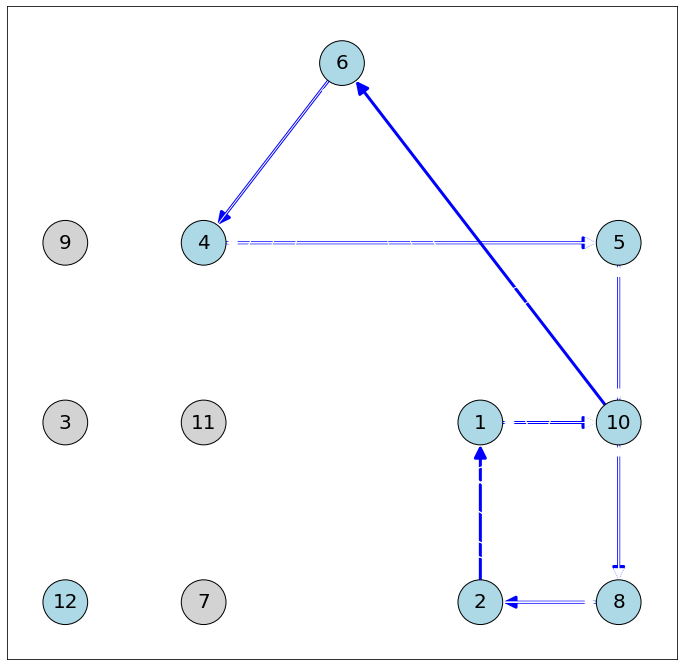

second vachile route


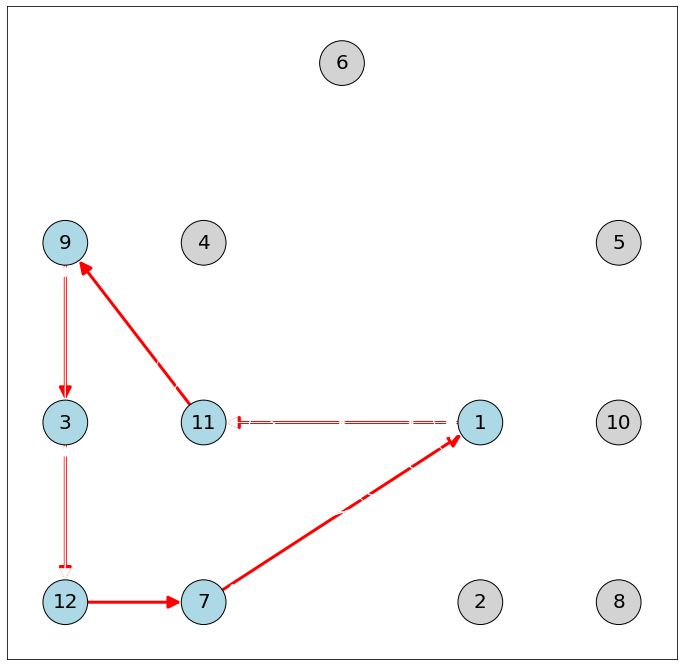

Route: 38040.0


In [ ]:
nodes1= {"Uşak","Afyon", "Aydın", "Balıkesir", "Bursa", "Çanakkale", "Denizli", "Eskisehir", "İzmir", "Kütahya", "Manisa", "Mugla"}
node_colors1 = ['lightblue' if i in path_nodes1   else 'lightgray' for i in graph.nodes] # pathnodeleri gri iseler onların rengin, mavi yap her i için

edge_widths = [3 if (i, j) in path_edges2 else 1 for (i, j) in graph.edges]
node_colors2 = ['lightblue' if i in path_nodes2   else 'lightgray'  for i in graph.nodes]
edge_colors2 = ['blue' if (i, j) in path_edges2 else 'white' for (i, j) in graph.edges]
fig, ax = plt.subplots(figsize=(12, 12))

nx.draw_networkx_nodes(graph, pos=pos, ax=ax, node_color=node_colors2, edgecolors='black', node_size=2000)

nx.draw_networkx_labels(graph, pos=pos, ax=ax, labels= dict(zip(nodes, nodes)), font_size=20)
nx.draw_networkx_edges(graph, pos=pos, ax=ax, node_size=2000, arrowsize=25, edge_color=edge_colors2, width=edge_widths)
nx.draw_networkx_edges
print ("first vachile route")

plt.show() 




edge_colors1 = ['red' if (i, j) in path_edges1 else 'white' for (i, j) in graph.edges] # her i j için eğer path edgenin içerisinde ise mavi yap çizgiyi

edge_widths = [3 if (i, j) in path_edges1 else 1 for (i, j) in graph.edges] #  eğer path_ eğer içerisnde ise çizgiyi kalınlaştır 
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_nodes(graph, pos=pos, ax=ax, node_color=node_colors1, edgecolors='black', node_size=2000)

nx.draw_networkx_labels(graph, pos=pos, ax=ax, labels=dict(zip(nodes, nodes)), font_size=20)
nx.draw_networkx_edges(graph, pos=pos, ax=ax, node_size=2000, arrowsize=25, edge_color=edge_colors1, width=edge_widths)
nx.draw_networkx_edges
print ("second vachile route")
plt.show() 


print("Route:", pyo.value(model.obj_val))

Optimal routes are simulated above.


 The routes are shown on the map below.

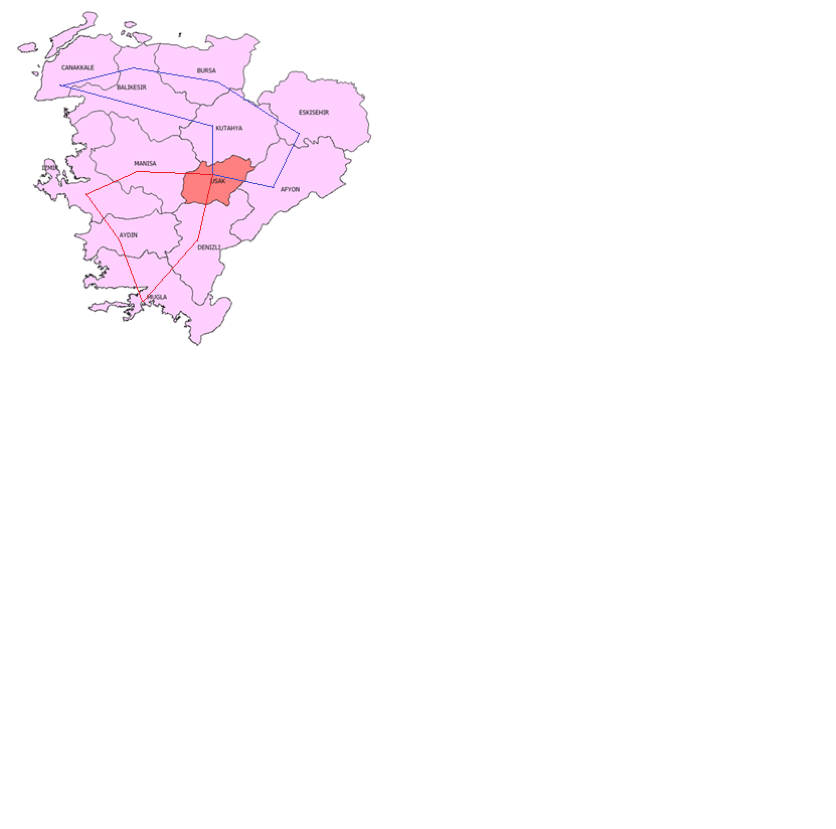

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
url=   'https://drive.google.com/file/d/1GfwJep59irOXXhS7P6uYlSfCLvZclmI2/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
img = img.imread(path)
#img = img.imread('citysol.png')
plt.subplots(figsize=(15, 15))
plt. axis("off")
imgplot = plt.imshow(img)

The blue route and the red route in the picture are the routes of each truck.